# Profitability - Group Project on Stock Price Movement

In [35]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

## CLEANING

In [36]:
fundamentals = pd.read_csv('fundamentals.csv',index_col = 0)
price_split=pd.read_csv('prices-split-adjusted.csv')
securities = pd.read_csv('securities.csv')
sectors = securities['GICS Sector'].unique()
sub_industry = securities['GICS Sub Industry'].unique()
accounts = fundamentals.columns.values[2:]

In [37]:
fundamentals = fundamentals.rename(columns={'Period Ending': 'date'})
fundamentals = fundamentals.rename(columns={'Ticker Symbol': 'symbol'})

In [38]:
new_data=pd.merge(fundamentals, price_split, on='date', how='left')
new_data1=new_data[new_data["symbol_x"]==new_data["symbol_y"]]
new_data1.drop(['symbol_y'], axis=1,inplace=True)
new_data1=new_data1.rename(columns={'symbol_x':'symbol'})

/Users/zhongyizhang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
securities=securities.rename(columns={'Ticker symbol':'symbol'})

In [40]:
new_data2=pd.merge(new_data1, securities, on='symbol', how='left')

In [41]:
#create the For year column again to get rid of null values
new_data2['For Year']=new_data2.date.str.split("-",expand=True,)[0]

In [42]:
new_data2[['SEC filings']].describe()

,SEC filings
count,1357
unique,1
top,reports
freq,1357


In [43]:
new_data2[['GICS Sector']].describe()

,GICS Sector
count,1357
unique,11
top,Industrials
freq,208


In [44]:
new_data2[['GICS Sub Industry']].describe()

,GICS Sub Industry
count,1357
unique,114
top,Industrial Conglomerates
freq,65


In [45]:
new_data2.drop(['symbol'], axis=1,inplace=True)
new_data2.drop(['date'], axis=1,inplace=True)
new_data2.drop(['CIK'], axis=1,inplace=True)
new_data2.drop(['SEC filings'], axis=1,inplace=True)
new_data2.drop(['Security'], axis=1,inplace=True)
#drop Equity Earnings/Loss Unconsolidated Subsidiary because 60% of the data is zero??
new_data2.drop(['Equity Earnings/Loss Unconsolidated Subsidiary'], axis=1,inplace=True)
#I believe Sector will be a stronger feature
new_data2.drop(['GICS Sub Industry'], axis=1,inplace=True)
new_data2.drop(['Address of Headquarters'], axis=1,inplace=True)
new_data2.drop(['Date first added'], axis=1,inplace=True)
#add back later
new_data2.drop(['GICS Sector'], axis=1,inplace=True)
new_data2.drop(['For Year'], axis=1,inplace=True)

In [46]:
new_data2['PE'] = new_data2['close'] / new_data2['Earnings Per Share']

In [47]:
#missing EPS valuses as zero because its possible the company wasnt public
new_data2[['Earnings Per Share']] = new_data2[['Earnings Per Share']].fillna(value=0)
new_data2[['PE']] = new_data2[['PE']].fillna(value=0)

In [48]:
pd.set_option('display.max_rows', 500)
total = new_data2.isnull().sum()
percent_1 = new_data2.isnull().sum()/new_data2.isnull().count()*100
percent_2 = (round(percent_1, 2))
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
print(missing_data)

                                                    Total      %
Accounts Payable                                        0   0.00
Accounts Receivable                                     0   0.00
Add'l income/expense items                              0   0.00
After Tax ROE                                           0   0.00
Capital Expenditures                                    0   0.00
Capital Surplus                                         0   0.00
Cash Ratio                                            272  20.04
Cash and Cash Equivalents                               0   0.00
Changes in Inventories                                  0   0.00
Common Stocks                                           0   0.00
Cost of Revenue                                         0   0.00
Current Ratio                                         272  20.04
Deferred Asset Charges                                  0   0.00
Deferred Liability Charges                              0   0.00
Depreciation             

In [49]:
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
fastknn_data=fast_knn(new_data2.values, k=30)

In [50]:
clean_data = pd.DataFrame.from_records(fastknn_data, columns = new_data2.columns)
clean_data.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Revenue,Treasury Stock,Earnings Per Share,Estimated Shares Outstanding,open,close,low,high,volume,PE
0,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,...,2.485500e+10,-367000000.0,-5.60,3.350000e+08,12.850000,13.500000,12.840000,13.680000,7005600.0,-2.410714
1,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,...,2.674300e+10,0.0,-11.25,1.630222e+08,24.740000,25.250000,24.629999,25.250000,7166600.0,-2.244444
2,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,...,4.265000e+10,0.0,4.02,7.169154e+08,53.900002,53.630001,53.320000,54.639999,10626000.0,13.340796
3,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,0.0,6000000.0,...,4.099000e+10,0.0,11.39,6.681299e+08,42.540001,42.349998,41.830002,42.570000,6788900.0,3.718174
4,6.448000e+09,681000000.0,-5.400000e+07,92.0,-4.910000e+08,3.671000e+09,144.0,9.595000e+09,-56000000.0,16000000.0,...,1.879000e+10,-320000000.0,2.58,1.600000e+09,52.990002,52.810001,52.360001,53.060001,3019700.0,20.468993


In [51]:
fundamentals['For Year'].isnull().sum()

173

In [52]:
clean_data['For Year']=fundamentals['For Year'].fillna(value=0).astype(int)

In [53]:
#add categories back
clean_data['GICS Sector']=securities['GICS Sector']
import category_encoders as ce
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
clean_data = ohe.fit_transform(clean_data)

In [54]:
clean_data['trend']=np.where(new_data2['PE']>0, '1', '0').astype(int)

In [55]:
clean_data.columns

Index(['Accounts Payable', 'Accounts Receivable', 'Add'l income/expense items',
       'After Tax ROE', 'Capital Expenditures', 'Capital Surplus',
       'Cash Ratio', 'Cash and Cash Equivalents', 'Changes in Inventories',
       'Common Stocks', 'Cost of Revenue', 'Current Ratio',
       'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Effect of Exchange Rate', 'Fixed Assets', 'Goodwill', 'Gross Margin',
       'Gross Profit', 'Income Tax', 'Intangible Assets', 'Interest Expense',
       'Inventory', 'Investments', 'Liabilities', 'Long-Term Debt',
       'Long-Term Investments', 'Minority Interest', 'Misc. Stocks',
       'Net Borrowings', 'Net Cash Flow', 'Net Cash Flow-Operating',
       'Net Cash Flows-Financing', 'Net Cash Flows-Investing', 'Net Income',
       'Net Income Adjustments',
       'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Net Re

In [56]:
#drop PE and columns directly related to profitability
clean_data.drop(['PE'], axis=1,inplace=True)
clean_data.drop(['Earnings Per Share'], axis=1,inplace=True)

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(clean_data.loc[:, clean_data.columns != 'trend'], clean_data['trend'], test_size=0.30, random_state=42)

In [162]:
clean_data.shape

(1357, 92)

In [163]:
# scikit-learn bootstrap
from sklearn.utils import resample

boot = resample(clean_data, replace=True, n_samples=51, random_state=1)
print('Bootstrap Sample: %s' % boot)

oob = [x for x in clean_data if x not in boot]
print('OOB Sample: %s' % oob)

Bootstrap Sample:       Accounts Payable  Accounts Receivable  Add'l income/expense items  \
1061      8.580000e+08        -3.300000e+07                9.100000e+07   
235       1.936000e+09        -6.800000e+07                1.064000e+09   
1096      2.273380e+09        -1.393800e+07                5.382500e+07   
905       1.040800e+09        -5.700000e+07                7.000000e+06   
715       5.939000e+08        -1.640000e+07                4.400000e+06   
847       3.021000e+09         1.190000e+08               -1.200000e+07   
960       1.441000e+09         1.300000e+07                7.900000e+07   
144       1.130000e+10        -5.600000e+07                0.000000e+00   
129       9.950000e+08        -4.600000e+07                0.000000e+00   
749       2.476000e+09        -1.700000e+07                3.800000e+07   
508       6.434000e+08        -6.800000e+07               -1.670000e+07   
1305      9.180000e+08         2.900000e+07                3.800000e+07   
1202   

In [164]:
boot.shape

(52, 92)

In [165]:
clean = clean_data.copy()

In [166]:
clean = clean.append(boot)

In [167]:
clean.shape

(1409, 92)

In [168]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(clean.loc[:, clean.columns != 'trend'], 
                                                    clean['trend'], test_size=0.30, random_state=42)

In [169]:
#lbfgs would not converge
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
log_model = logreg.fit(X_train, Y_train)

log_Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
test_acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_log)
print("Accuracy score (test):",test_acc_log)

Accuracy score (training): 91.48
Accuracy score (test): 91.02


In [170]:
from sklearn.metrics import roc_auc_score

model=logreg

train_predictions = model.predict(X_train)

test_accuracy = roc_auc_score(Y_train, train_predictions)
test_error_rate = 1 - test_accuracy
print('ROC Test Accuracy: {:.2f} | ROC Test Error: {:.2f}'.format(test_accuracy, test_error_rate))
train_accuracy = roc_auc_score(Y_test, log_Y_pred)
train_error_rate = 1 - train_accuracy
print('ROC Train Accuracy: {:.2f} | ROC Train Error: {:.2f}'.format(train_accuracy, train_error_rate))

#error test > error train => OVER FITTING of the data.
#error test < error train => UNDER FITTING of the data

print('OVERFIT:',test_error_rate > train_error_rate)
print('UNDERFIT:',test_error_rate < train_error_rate)

ROC Test Accuracy: 0.71 | ROC Test Error: 0.29
ROC Train Accuracy: 0.70 | ROC Train Error: 0.30
OVERFIT: False
UNDERFIT: True


## RMSE

In [24]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = MSE(y_train, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = MSE(y_test, predictions)
    rmse = np.sqrt(mse)
    return rmse

def calc_cv_error(X_train, Y_train, model):
    mse = - cross_val_score(model, X_train, Y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1)
    
    rmse = float((mse.mean())**(1/2))
    return rmse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    cv_error = calc_cv_error(X_test, y_test, model)
    return train_error, validation_error, cv_error

## Logistic Regression

In [25]:
#lbfgs would not converge
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
log_model = logreg.fit(X_train, Y_train)

log_Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
test_acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_log)
print("Accuracy score (test):",test_acc_log)

Accuracy score (training): 91.78
Accuracy score (test): 87.75


In [26]:
model=logreg

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

lr_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.29 | test error: 0.35
CV error: 0.38
train/test: 1.2


## K-Nearest Neighbors

In [27]:
knn = KNeighborsClassifier() 
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_neighbors': [2, 5, 10, 50, 100],
    'p' : [1, 2],
    'leaf_size' :[30,50]
}

knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 10, n_jobs=-1)
knn_CV.fit(X_train, Y_train)

print(knn_CV.best_params_)
print(knn_CV.best_score_)

{'leaf_size': 30, 'n_neighbors': 5, 'p': 1}
0.8914646996838778


In [29]:
knn = KNeighborsClassifier(leaf_size=30, n_neighbors=5, p=2) 
knn_model = knn.fit(X_train, Y_train)  
knn_Y_pred = knn.predict(X_test)  

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
test_acc_knn = round(knn.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_knn)
print("Accuracy score (test):",test_acc_knn)

Accuracy score (training): 91.46
Accuracy score (test): 89.95


In [30]:
#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

model=knn

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

knn_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.29 | test error: 0.32
CV error: 0.32
train/test: 1.1


## Gaussian Naive Bayes

In [31]:
gaussian = GaussianNB()
gaussian_model = gaussian.fit(X_train, Y_train) 

gaussian_Y_pred = gaussian.predict(X_test)  

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
test_acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_gaussian)
print("Accuracy score (test):",test_acc_gaussian)

Accuracy score (training): 30.14
Accuracy score (test): 23.53


In [32]:
model=gaussian

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

gaussian_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.84 | test error: 0.87
CV error: 0.84
train/test: 1.0


## Support Vector Classifier (SVC)

In [33]:
svc = SVC(kernel='rbf', gamma='auto')
svc_model = svc.fit(X_train, Y_train)

svc_Y_pred = svc.predict(X_test)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
test_acc_svc = round(svc.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_svc)
print("Accuracy score (test):",test_acc_svc)

Accuracy score (training): 100.0
Accuracy score (test): 89.71


In [34]:
model=svc

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

svc_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.00 | test error: 0.32
CV error: 0.32
train/test: inf


C:\Users\Sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


## Decision Trees

In [35]:
decision_tree = DecisionTreeClassifier() 
decision_tree.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [36]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth' : depths,
    'min_samples_leaf' :[1, 5, 10, 20, 50, 100]
}

decision_tree_CV = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv= 10, n_jobs=-1)
decision_tree_CV.fit(X_train, Y_train)

print(decision_tree_CV.best_params_)
print(decision_tree_CV.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5}
0.946259220231823


In [37]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5) 
decision_tree_model = decision_tree.fit(X_train, Y_train)  
decision_tree_Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
test_acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_decision_tree)
print("Accuracy score (test):",test_acc_decision_tree)

Accuracy score (training): 96.42
Accuracy score (test): 94.85


In [38]:
model=decision_tree

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

dt_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.19 | test error: 0.24
CV error: 0.27
train/test: 1.3


## Ensemble Methods

### AdaBoost

In [39]:
decision_tree = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator=decision_tree, n_estimators=180, random_state=1)
ada_model = ada.fit(X_train, Y_train)

ada_Y_pred = ada.predict(X_test)

acc_ada = round(ada.score(X_train, Y_train) * 100, 2)
test_acc_ada = round(ada.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_ada)
print("Accuracy score (test):",test_acc_ada)

Accuracy score (training): 100.0
Accuracy score (test): 91.18


In [40]:
model=ada

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

ada_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.00 | test error: 0.30
CV error: 0.32
train/test: inf


C:\Users\Sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


### Gradient Tree Boosting

In [41]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gt_model = gb.fit(X_train, Y_train)
    
    acc_gb = round(gb.score(X_train, Y_train) * 100, 2)
    test_acc_gb = round(gb.score(X_test, Y_test) * 100, 2)
    
    gb_Y_pred = gb.predict(X_test)
    
print("Learning rate: ", learning_rate)
print("Accuracy score (training):",acc_gb)
print("Accuracy score (test):",test_acc_gb)

Learning rate:  1
Accuracy score (training): 94.94
Accuracy score (test): 90.93


In [42]:
model=gb

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

gb_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.22 | test error: 0.30
CV error: 0.36
train/test: 1.3


### Random Forest

In [43]:
random_forest = RandomForestClassifier()
random_forest.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [44]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : depths,
    'criterion' :['gini', 'entropy']
}

rf_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_CV.fit(X_train, Y_train)

print(rf_CV.best_params_)
print(rf_CV.best_score_)

{'criterion': 'entropy', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 200}
0.9420442571127503


In [45]:
random_forest = RandomForestClassifier(criterion='entropy', max_depth=11, max_features='auto', n_estimators=200)
random_forest_model = random_forest.fit(X_train, Y_train)

random_Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
test_acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_random_forest)
print("Accuracy score (test):",test_acc_random_forest)

Accuracy score (training): 99.58
Accuracy score (test): 95.1


In [46]:
model=random_forest

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

rf_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.06 | test error: 0.22
CV error: 0.23
train/test: 3.4


In [100]:
.22 > .06

True

In [47]:
# Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Net Income Applicable to Common Shareholders,0.078
Net Income,0.076
Earnings Before Tax,0.059
Net Income-Cont. Operations,0.055
Earnings Before Interest and Tax,0.048
Estimated Shares Outstanding,0.032
Income Tax,0.022
Operating Income,0.020
Cash and Cash Equivalents,0.018


## Stochastic Gradient Descent (SGD)

In [48]:
sgd = linear_model.SGDClassifier()
sgd.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2'],
}

sgd_CV = GridSearchCV(estimator=sgd, param_grid=param_grid, cv= 5, n_jobs=-1)
sgd_CV.fit(X_train, Y_train)

print(sgd_CV.best_params_)
print(sgd_CV.best_score_)

{'loss': 'squared_hinge', 'penalty': 'l2'}
0.8788198103266597


C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [50]:
sgd = linear_model.SGDClassifier(loss='squared_hinge', penalty='l2',max_iter=1000)
sgd_model = sgd.fit(X_train, Y_train)
sgd_Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
test_acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_sgd)
print("Accuracy score (test):",test_acc_sgd)

Accuracy score (training): 89.46
Accuracy score (test): 89.46


In [51]:
model=sgd

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

sgd_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.35 | test error: 0.34
CV error: 0.42
train/test: 1.0


## Perceptron

In [52]:
perceptron = Perceptron(max_iter=5)
perceptron_model = perceptron.fit(X_train, Y_train)

perceptron_Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
test_acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_perceptron)
print("Accuracy score (test):",test_acc_perceptron)

Accuracy score (training): 88.2
Accuracy score (test): 89.71


In [53]:
model=perceptron

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

perceptron_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.34 | test error: 0.32
CV error: 0.37
train/test: 0.9


## COMPARE

In [54]:
results = pd.DataFrame({
    'Model': ['Logistic Regression','K-Nearest Neighbors',
             'Gaussian Naive Bayes','Support Vector Classifier (SVC)',
             'Decision Trees','AdaBoost','Gradient Tree Boosting',
             'Random Forest','Stochastic Gradient Descent (SGD)','Perceptron'],
    'Score': [test_acc_log,
              test_acc_knn,
              test_acc_gaussian,
              test_acc_svc,
              test_acc_decision_tree,
              test_acc_ada,
              test_acc_gb,
              test_acc_random_forest,
              test_acc_sgd,
              test_acc_perceptron],
    'CV Error': [round(lr_cv_error, 2),
                round(knn_cv_error, 2),
                round(gaussian_cv_error, 2),
                round(svc_cv_error, 2),
                round(dt_cv_error, 2),
                round(ada_cv_error, 2),
                round(gb_cv_error, 2),
                round(rf_cv_error, 2),
                round(sgd_cv_error, 2),
                round(perceptron_cv_error, 2)
                ]})
result_df = results.sort_values(by='CV Error', ascending=True)
result_df = result_df.set_index('Score')
result_df

,Model,CV Error
Score,,
95.10,Random Forest,0.23
94.85,Decision Trees,0.27
89.95,K-Nearest Neighbors,0.32
89.71,Support Vector Classifier (SVC),0.32
91.18,AdaBoost,0.32
90.93,Gradient Tree Boosting,0.36
87.75,Logistic Regression,0.37
89.71,Perceptron,0.37
89.46,Stochastic Gradient Descent (SGD),0.42


# PCA

In [55]:
clean_data2=clean_data.copy()
#temp dropping trend
clean_data2.drop(['trend'], axis=1,inplace=True)

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def fit_pca(df, n_components):
    pca = PCA(n_components)
    pca.fit(df)   
    return pca

In [57]:
def standardize(df):
    stscaler = StandardScaler().fit(df)
    scaled = stscaler.transform(df)    
    return scaled

In [58]:
scaled = standardize(clean_data2)

C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [59]:
pca = fit_pca(scaled, n_components=25)

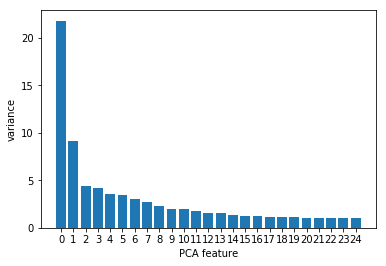

In [60]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

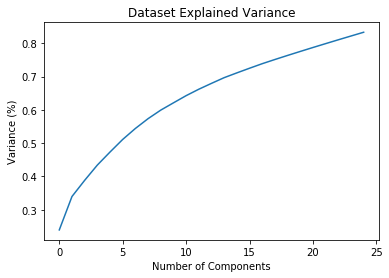

In [61]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

In [62]:
vars = pca.explained_variance_ratio_
c_names = ['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10',
           'f11','f12','f13','f14','f15','f16','f17','f18','f19','f20',
           'f21','f22','f23','f24','f25','f26','f27','f28','f29','f30',
           'f31','f32','f33','f34','f35','f36','f37','f38','f39','f40',
           'f41','f42','f43','f44','f45','f46','f47','f48','f49','f50',
           'f51','f52','f53','f54','f55','f56','f57','f58','f59','f60',
           'f61','f62','f63','f64','f65','f66','f67','f68','f69','f70',
           'f71','f72','f73','f74','f75','f76','f77','f78','f79','f80',
           'f81','f82']

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) for val, name in zip(row, c_names))
    print(output)

Variance:  Projected dimension
------------------------------
24.0%:     0.18 * f1 +  0.02 * f2 +  0.06 * f3 + -0.01 * f4 + -0.12 * f5 +  0.13 * f6 + -0.01 * f7 +  0.15 * f8 + -0.03 * f9 +  0.10 * f10 +  0.11 * f11 + -0.02 * f12 +  0.04 * f13 +  0.11 * f14 +  0.14 * f15 +  0.20 * f16 +  0.18 * f17 + -0.09 * f18 +  0.12 * f19 +  0.14 * f20 + -0.01 * f21 +  0.17 * f22 +  0.17 * f23 +  0.08 * f24 +  0.15 * f25 +  0.07 * f26 + -0.09 * f27 +  0.00 * f28 +  0.15 * f29 +  0.15 * f30 +  0.10 * f31 +  0.01 * f32 + -0.03 * f33 + -0.01 * f34 +  0.18 * f35 +  0.00 * f36 + -0.12 * f37 +  0.18 * f38 + -0.02 * f39 +  0.18 * f40 +  0.18 * f41 +  0.15 * f42 +  0.05 * f43 +  0.16 * f44 + -0.02 * f45 +  0.09 * f46 +  0.08 * f47 +  0.14 * f48 + -0.07 * f49 +  0.09 * f50 + -0.01 * f51 +  0.04 * f52 +  0.05 * f53 +  0.11 * f54 + -0.01 * f55 + -0.01 * f56 + -0.01 * f57 + -0.01 * f58 +  0.05 * f59 +  0.17 * f60 + -0.09 * f61 +  0.19 * f62 +  0.15 * f63 +  0.06 * f64 +  0.17 * f65 +  0.10 * f66 +  0.12 * f67 +

In [63]:
pca = PCA(n_components=20)
reduced = pca.fit_transform(scaled)

In [64]:
reduced_df = pd.DataFrame.from_records(reduced)
reduced_df.insert(0, column='trend', value=clean_data.trend)
reduced_df['trend']=reduced_df['trend'].astype(np.int)
reduced_df.head()

,trend,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,-1.529243,-0.481346,-2.197566,0.090869,-0.731091,0.606685,0.598433,-1.636677,0.831224,...,-0.093330,0.667153,-0.799428,-1.049478,0.462469,-0.032835,0.600083,1.213314,0.229505,0.310986
1,0,-0.926681,-0.245931,-1.709170,0.236085,-0.314797,1.279131,1.113337,-1.488044,1.260740,...,0.327529,0.356832,-0.994108,-1.567556,1.288602,-1.569016,0.971225,0.064266,2.691992,-0.843703
2,1,1.399064,1.138583,-0.939195,0.386344,-0.274704,-0.011861,0.170389,-0.947434,0.428108,...,0.237320,0.924914,-1.382001,-0.657229,1.262096,-0.616028,1.009561,0.398582,2.580320,-0.731612
3,1,2.256706,1.542268,-1.092788,0.084575,0.064238,-0.090029,-0.116590,-0.242789,0.376564,...,-0.039250,0.458381,-2.280771,-0.770656,0.423003,-0.196471,0.334632,0.531126,-1.148052,1.080912
4,1,0.679101,0.681263,0.507259,1.303147,0.602425,1.715374,-1.717681,0.726001,0.258326,...,0.184980,0.438936,-1.938343,-0.961541,-0.923906,-0.185684,1.726113,0.760963,-1.901051,0.497231


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(reduced_df.iloc[:,1:], reduced_df['trend'], test_size=0.30, random_state=42)

## Logistic Regression

In [67]:
#lbfgs would not converge
#For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
log_model = logreg.fit(X_train, Y_train)

log_Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
test_acc_log = round(logreg.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_log)
print("Accuracy score (test):",test_acc_log)

Accuracy score (training): 89.57
Accuracy score (test): 90.93


In [68]:
model=logreg

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

lr_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.32 | test error: 0.30
CV error: 0.32
train/test: 0.9


## K-Nearest Neighbors

In [69]:
knn = KNeighborsClassifier() 
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [70]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_neighbors': [2, 5, 10, 50, 100],
    'p' : [1, 2],
    'leaf_size' :[30,50]
}

knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 10, n_jobs=-1)
knn_CV.fit(X_train, Y_train)

print(knn_CV.best_params_)
print(knn_CV.best_score_)

{'leaf_size': 30, 'n_neighbors': 5, 'p': 2}
0.8840885142255005


In [71]:
knn = KNeighborsClassifier(leaf_size=30, n_neighbors=5, p=2) 
knn_model = knn.fit(X_train, Y_train)  
knn_Y_pred = knn.predict(X_test)  

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
test_acc_knn = round(knn.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_knn)
print("Accuracy score (test):",test_acc_knn)

Accuracy score (training): 91.36
Accuracy score (test): 89.95


In [72]:
#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

model=knn

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

knn_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.29 | test error: 0.32
CV error: 0.32
train/test: 1.1


## Gaussian Naive Bayes

In [73]:
gaussian = GaussianNB()
gaussian_model = gaussian.fit(X_train, Y_train) 

gaussian_Y_pred = gaussian.predict(X_test)  

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
test_acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_gaussian)
print("Accuracy score (test):",test_acc_gaussian)

Accuracy score (training): 50.79
Accuracy score (test): 48.28


In [74]:
model=gaussian

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

gaussian_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.70 | test error: 0.72
CV error: 0.34
train/test: 1.0


## Support Vector Classifier (SVC)

In [75]:
svc = SVC(kernel='rbf', gamma='auto')
svc_model = svc.fit(X_train, Y_train)

svc_Y_pred = svc.predict(X_test)

acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
test_acc_svc = round(svc.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_svc)
print("Accuracy score (test):",test_acc_svc)

Accuracy score (training): 90.73
Accuracy score (test): 90.2


In [76]:
model=svc

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

svc_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.30 | test error: 0.31
CV error: 0.32
train/test: 1.0


## Decision Trees

In [77]:
decision_tree = DecisionTreeClassifier() 
decision_tree.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [78]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth' : depths,
    'min_samples_leaf' :[1, 5, 10, 20, 50, 100]
}

decision_tree_CV = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv= 10, n_jobs=-1)
decision_tree_CV.fit(X_train, Y_train)

print(decision_tree_CV.best_params_)
print(decision_tree_CV.best_score_)

{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1}
0.8819810326659642


In [79]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=1) 
decision_tree_model = decision_tree.fit(X_train, Y_train)  
decision_tree_Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
test_acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_decision_tree)
print("Accuracy score (test):",test_acc_decision_tree)

Accuracy score (training): 88.62
Accuracy score (test): 90.2


In [80]:
model=decision_tree

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

dt_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.34 | test error: 0.31
CV error: 0.34
train/test: 0.9


## Ensemble Methods

### AdaBoost

In [81]:
decision_tree = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator=decision_tree, n_estimators=180, random_state=1)
ada_model = ada.fit(X_train, Y_train)

ada_Y_pred = ada.predict(X_test)

acc_ada = round(ada.score(X_train, Y_train) * 100, 2)
test_acc_ada = round(ada.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_ada)
print("Accuracy score (test):",test_acc_ada)

Accuracy score (training): 100.0
Accuracy score (test): 86.52


In [82]:
model=ada

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

ada_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.00 | test error: 0.37
CV error: 0.42
train/test: inf


C:\Users\Sasha\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


### Gradient Tree Boosting

In [83]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gt_model = gb.fit(X_train, Y_train)
    
    acc_gb = round(gb.score(X_train, Y_train) * 100, 2)
    test_acc_gb = round(gb.score(X_test, Y_test) * 100, 2)
    
    gb_Y_pred = gb.predict(X_test)
    
print("Learning rate: ", learning_rate)
print("Accuracy score (training):",acc_gb)
print("Accuracy score (test):",test_acc_gb)

Learning rate:  1
Accuracy score (training): 92.62
Accuracy score (test): 88.48


In [84]:
model=gb

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

gb_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.27 | test error: 0.34
CV error: 0.35
train/test: 1.2


### Random Forest

In [85]:
random_forest = RandomForestClassifier()
random_forest.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [86]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : depths,
    'criterion' :['gini', 'entropy']
}

rf_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 5, n_jobs=-1)
rf_CV.fit(X_train, Y_train)

print(rf_CV.best_params_)
print(rf_CV.best_score_)

{'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 200}
0.8956796628029505


In [87]:
random_forest = RandomForestClassifier(criterion='gini', max_depth=11, max_features='sqrt', n_estimators=200)
random_forest_model = random_forest.fit(X_train, Y_train)

random_Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
test_acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_random_forest)
print("Accuracy score (test):",test_acc_random_forest)

Accuracy score (training): 98.74
Accuracy score (test): 90.93


In [88]:
model=random_forest

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

rf_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.13 | test error: 0.30
CV error: 0.34
train/test: 2.4


In [89]:
# Feature Importance
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
0,0.087
2,0.079
1,0.073
4,0.062
8,0.051
12,0.049
11,0.048
3,0.047
18,0.047


## Stochastic Gradient Descent (SGD)

In [90]:
sgd = linear_model.SGDClassifier()
sgd.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [91]:
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2'],
}

sgd_CV = GridSearchCV(estimator=sgd, param_grid=param_grid, cv= 5, n_jobs=-1)
sgd_CV.fit(X_train, Y_train)

print(sgd_CV.best_params_)
print(sgd_CV.best_score_)

{'loss': 'squared_hinge', 'penalty': 'l2'}
0.8872497365648051


C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Sasha\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [92]:
sgd = linear_model.SGDClassifier(loss='squared_hinge', penalty='l2',max_iter=1000)
sgd_model = sgd.fit(X_train, Y_train)
sgd_Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
test_acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_sgd)
print("Accuracy score (test):",test_acc_sgd)

Accuracy score (training): 78.5
Accuracy score (test): 77.45


In [93]:
model=sgd

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

sgd_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.44 | test error: 0.48
CV error: 0.43
train/test: 1.1


## Perceptron

In [94]:
perceptron = Perceptron(max_iter=5)
perceptron_model = perceptron.fit(X_train, Y_train)

perceptron_Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
test_acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)

# Print roc_auc_score
print("Accuracy score (training):",acc_perceptron)
print("Accuracy score (test):",test_acc_perceptron)

Accuracy score (training): 87.25
Accuracy score (test): 88.24


In [95]:
model=perceptron

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

train_error, test_error, cv_error = calc_metrics(X_train, Y_train, X_test, Y_test, model)

perceptron_cv_error = cv_error

print('train error: {:.2f} | test error: {:.2f}'.format(train_error, test_error))
print('CV error: {:.2f}'.format(cv_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

#RMSE of test > RMSE of train => OVER FITTING of the data.
#RMSE of test < RMSE of train => UNDER FITTING of the data

train error: 0.36 | test error: 0.34
CV error: 0.43
train/test: 1.0


## COMPARE

In [98]:
results = pd.DataFrame({
    'Model': ['Logistic Regression','K-Nearest Neighbors',
             'Gaussian Naive Bayes','Support Vector Classifier (SVC)',
             'Decision Trees','AdaBoost','Gradient Tree Boosting',
             'Random Forest','Stochastic Gradient Descent (SGD)','Perceptron'],
    'Score': [test_acc_log,
              test_acc_knn,
              test_acc_gaussian,
              test_acc_svc,
              test_acc_decision_tree,
              test_acc_ada,
              test_acc_gb,
              test_acc_random_forest,
              test_acc_sgd,
              test_acc_perceptron],
    'CV Error': [round(lr_cv_error, 2),
                round(knn_cv_error, 2),
                round(gaussian_cv_error, 2),
                round(svc_cv_error, 2),
                round(dt_cv_error, 2),
                round(ada_cv_error, 2),
                round(gb_cv_error, 2),
                round(rf_cv_error, 2),
                round(sgd_cv_error, 2),
                round(perceptron_cv_error, 2)
                ]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model,CV Error
Score,,
90.93,Logistic Regression,0.32
90.93,Random Forest,0.34
90.20,Support Vector Classifier (SVC),0.32
90.20,Decision Trees,0.34
89.95,K-Nearest Neighbors,0.32
88.48,Gradient Tree Boosting,0.35
88.24,Perceptron,0.43
86.52,AdaBoost,0.42
77.45,Stochastic Gradient Descent (SGD),0.43
